# Kaggle : New York City Taxi Trip Duration

<img src="taxi.png">

# 1 EDA (Exploratory Data Analysis)

# purpose of  EDA

- Suggest hypotheses about the causes of observed phenomena
- Assess assumptions on which statistical inference will be based
- Support the selection of appropriate statistical tools and techniques
- Provide a basis for further data collection through surveys or experiments

# EDA methods
- Graphical techniques used in EDA are:
    - boxplot 
        - detailed feature (datetime by month, day of week, hours)
    - historgram or barplot (distribution) # bin = range of value
        - origin feature (pick lat,long, drop lat, long, duration, passenger count, flag)
        - detailed feature (datetime by month, day of week, hours)
    - scatter plot
        - duration vs distance = to check odd data
    - Parallel Coordinates vs Colormaps vs Andrews curves charts
    - odd ratio????

- Quantative methods:
    - Trimean == tukey method?

# 1.1 Understanding data 

In [1]:
from IPython.display import display
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from math import sin, cos, sqrt, atan2, radians
import seaborn as sns
import lightgbm as lgb
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.preprocessing import StandardScaler

%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

In [2]:
train = pd.read_csv("data/train.csv")
train.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


In [3]:
test = pd.read_csv("data/test.csv")
test.head()

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag
0,id3004672,1,2016-06-30 23:59:58,1,-73.988129,40.732029,-73.990173,40.756680,N
1,id3505355,1,2016-06-30 23:59:53,1,-73.964203,40.679993,-73.959808,40.655403,N
2,id1217141,1,2016-06-30 23:59:47,1,-73.997437,40.737583,-73.986160,40.729523,N
3,id2150126,2,2016-06-30 23:59:41,1,-73.956070,40.771900,-73.986427,40.730469,N
4,id1598245,1,2016-06-30 23:59:33,1,-73.970215,40.761475,-73.961510,40.755890,N


In [4]:
sample_submission = pd.read_csv("data/sample_submission.csv")
sample_submission.head()

,id,trip_duration
0,id3004672,959
1,id3505355,959
2,id1217141,959
3,id2150126,959
4,id1598245,959


# 1.1.a Data type and unit

# unit

### 1. latitude / longtitude = decimal degree 
- 111.32mm per 0.000001° / 11.132 m per 0.0001° / 1.1132 km per 0.01° / 111.32 km per 1.0°
- 14 demical degree
- ex) 40.767937 , -73.982155

### 2. datetime = year-month-day: hour-minute-second

### 3. vendor_id = 1, 2

### 4. passenger_count = 0,,,,9

### 4. store_and_fwd_flag = N, Y

### 6. duration = second
- ex) 455 sec = 7min 35sec


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
id                    1458644 non-null object
vendor_id             1458644 non-null int64
pickup_datetime       1458644 non-null object
dropoff_datetime      1458644 non-null object
passenger_count       1458644 non-null int64
pickup_longitude      1458644 non-null float64
pickup_latitude       1458644 non-null float64
dropoff_longitude     1458644 non-null float64
dropoff_latitude      1458644 non-null float64
store_and_fwd_flag    1458644 non-null object
trip_duration         1458644 non-null int64
dtypes: float64(4), int64(3), object(4)
memory usage: 122.4+ MB


In [6]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 625134 entries, 0 to 625133
Data columns (total 9 columns):
id                    625134 non-null object
vendor_id             625134 non-null int64
pickup_datetime       625134 non-null object
passenger_count       625134 non-null int64
pickup_longitude      625134 non-null float64
pickup_latitude       625134 non-null float64
dropoff_longitude     625134 non-null float64
dropoff_latitude      625134 non-null float64
store_and_fwd_flag    625134 non-null object
dtypes: float64(4), int64(2), object(3)
memory usage: 42.9+ MB


In [7]:
sample_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 625134 entries, 0 to 625133
Data columns (total 2 columns):
id               625134 non-null object
trip_duration    625134 non-null int64
dtypes: int64(1), object(1)
memory usage: 9.5+ MB


# train data
-  1.4M data, 11 columns

# test data
-  0.6M data, 9 columns (no dropoff_datetime, trip_duration)

# sample_submission
-  0.6M data, 2 columns (id, trip_duration)

# 1.1.b Missing Data check

In [8]:
#none of missing data
train2 = train.dropna(how = 'any')
test2 = test.dropna(how = 'any')
len(train) == len(train2), len(test) == len(test2)

(True, True)

# 1.1.c Trip duration check

In [9]:
train["pickup_datetime"] =  pd.to_datetime(train["pickup_datetime"])
train["dropoff_datetime"] =  pd.to_datetime(train["dropoff_datetime"])
sample_duration = train["dropoff_datetime"] - train["pickup_datetime"]
sample_duration_sec = sample_duration.dt.total_seconds().astype('int')
train['trip_sec'] =  sample_duration_sec

In [10]:
train_d = train[train["trip_duration"] != train["trip_sec"]]
print(len(train_d))

if len(train_d) == 0:
    train = train.drop(['trip_sec'], axis=1)

train.head()

0


,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


### NYC Taxi Trip Duration [Train data]는

### 총 1,458,644 Row와 11 Column으로 구성되어 있으며,

### Missing Data는 존재하지 않습니다.

# 1.1.c Column information

- id : 개별 Taxi에 부여된 고유 id (이건 그냥 쓴거예요...)
- verdor_id : Taxi Company id >>>  1, 2로 구성되어 있는걸로 봐서 2개의 회사를 대상
- pickup/dropoff datetime : 출발/도착 시간정보 >> 년, 월, 일, 시각 정보가 포함
- passenger_count : 승객수 >>> 0~9명까지 존재
- pickup/dropoff_longitude & latitude : 출발/도착 지리정보
- store_and_fwd_flag : whether the trip data was sent immediately to the vendor (“N”) or held in the memory of the taxi because there was no connection to the server (“Y”)
- trip_duration : 탑승시간 >>> 단위는 Seconds

# 1.2 Feature Engineering & Data Cleaning

### 1.2.a Add columns with detailed informations


- duration per min
- datetime per hour
- datetime per day of week
- datetime per month

# date time convert

In [11]:
train = train.drop("dropoff_datetime", axis=1)

In [12]:
#data type convert to datetime from object
train["pickup_datetime"] =  pd.to_datetime(train["pickup_datetime"])
test["pickup_datetime"] =  pd.to_datetime(test["pickup_datetime"])

In [13]:
#day of week
#Monday=0, Sunday=6
train["pick_month"] = train["pickup_datetime"].apply(lambda x : x.month)
train["pick_day"] = train["pickup_datetime"].apply(lambda x : x.day)
train["pick_hour"] = train["pickup_datetime"].apply(lambda x : x.hour)
train["pick_min"] = train["pickup_datetime"].apply(lambda x : x.minute)
train["pick_sec"] = train["pickup_datetime"].apply(lambda x : x.second)

#day of week
#Monday=0, Sunday=6
test["pick_month"] = test["pickup_datetime"].apply(lambda x : x.month)
test["pick_day"] = test["pickup_datetime"].apply(lambda x : x.day)
test["pick_hour"] = test["pickup_datetime"].apply(lambda x : x.hour)
test["pick_min"] = test["pickup_datetime"].apply(lambda x : x.minute)
test["pick_sec"] = test["pickup_datetime"].apply(lambda x : x.second)

In [14]:
train = train.drop('pickup_datetime', axis=1)
test = test.drop('pickup_datetime', axis=1)

In [15]:
train.head()

,id,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pick_month,pick_day,pick_hour,pick_min,pick_sec
0,id2875421,2,1,-73.982155,40.767937,-73.964630,40.765602,N,455,3,14,17,24,55
1,id2377394,1,1,-73.980415,40.738564,-73.999481,40.731152,N,663,6,12,0,43,35
2,id3858529,2,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,1,19,11,35,24
3,id3504673,2,1,-74.010040,40.719971,-74.012268,40.706718,N,429,4,6,19,32,31
4,id2181028,2,1,-73.973053,40.793209,-73.972923,40.782520,N,435,3,26,13,30,55


In [16]:
test.head()

,id,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,pick_month,pick_day,pick_hour,pick_min,pick_sec
0,id3004672,1,1,-73.988129,40.732029,-73.990173,40.756680,N,6,30,23,59,58
1,id3505355,1,1,-73.964203,40.679993,-73.959808,40.655403,N,6,30,23,59,53
2,id1217141,1,1,-73.997437,40.737583,-73.986160,40.729523,N,6,30,23,59,47
3,id2150126,2,1,-73.956070,40.771900,-73.986427,40.730469,N,6,30,23,59,41
4,id1598245,1,1,-73.970215,40.761475,-73.961510,40.755890,N,6,30,23,59,33


# 1.2.b Distance between pickup and dropoff location

# Geographic space
   - Manhattan distance vs Euclidean distance

### Euclidean distance
- unit = km

# New York border coordinate

In [17]:
# new york city coordinate = (41.145495, −73.994901)
city_long_border = (-74.03, -73.75)
city_lat_border = (40.63, 40.85)

# Distance

In [18]:
train.head()

,id,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pick_month,pick_day,pick_hour,pick_min,pick_sec
0,id2875421,2,1,-73.982155,40.767937,-73.964630,40.765602,N,455,3,14,17,24,55
1,id2377394,1,1,-73.980415,40.738564,-73.999481,40.731152,N,663,6,12,0,43,35
2,id3858529,2,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,1,19,11,35,24
3,id3504673,2,1,-74.010040,40.719971,-74.012268,40.706718,N,429,4,6,19,32,31
4,id2181028,2,1,-73.973053,40.793209,-73.972923,40.782520,N,435,3,26,13,30,55


In [19]:
# approximate radius of earth in km
# train
R = 6371.0

dist = []

for i in range(len(train)):
    lat1 = radians(train.iloc[i,4])
    lon1 = radians(train.iloc[i,3])
    lat2 = radians(train.iloc[i,6])
    lon2 = radians(train.iloc[i,5])

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))

    distance = R * c
    dist.append(distance)
    
train['ucli_distance'] = dist

In [20]:
# approximate radius of earth in km
# test
R = 6371.0

dist = []

for i in range(len(test)):
    lat1 = radians(test.iloc[i,4])
    lon1 = radians(test.iloc[i,3])
    lat2 = radians(test.iloc[i,6])
    lon2 = radians(test.iloc[i,5])

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))

    distance = R * c
    dist.append(distance)
    
test['ucli_distance'] = dist

In [21]:
train['man_distance'] = (abs(train.dropoff_longitude - train.pickup_longitude) + abs(train.dropoff_latitude - train.pickup_latitude))
test['man_distance'] = (abs(test.dropoff_longitude - test.pickup_longitude) + abs(test.dropoff_latitude - test.pickup_latitude))

## 2.2 Direction

In [22]:
def direction_distance(pickup_lat, pickup_long, dropoff_lat, dropoff_long):
    '''Calculate the direction of travel in degrees'''
    pickup_lat_rads = np.radians(pickup_lat)
    pickup_long_rads = np.radians(pickup_long)
    dropoff_lat_rads = np.radians(dropoff_lat)
    dropoff_long_rads = np.radians(dropoff_long)
    long_delta_rads = np.radians(dropoff_long_rads - pickup_long_rads)
    
    y = np.sin(long_delta_rads) * np.cos(dropoff_lat_rads)
    x = (np.cos(pickup_lat_rads) * np.sin(dropoff_lat_rads) - np.sin(pickup_lat_rads) * np.cos(dropoff_lat_rads) * np.cos(long_delta_rads))
    
    return np.degrees(np.arctan2(y, x))

In [23]:
train['direction_distance'] = direction_distance(train.pickup_latitude, train.pickup_longitude, train.dropoff_latitude, train.dropoff_longitude)
test['direction_distance'] = direction_distance(test.pickup_latitude, test.pickup_longitude, test.dropoff_latitude, test.dropoff_longitude)

# 1.2.c Outlier Removal

### qualitative analysis
- 
- 
- 

### quantitative analysis
- Peirce's criterion
- Tukey's fences
- In anomaly detection
- Modified Thompson Tau test

# qualitative analysis

In [24]:
train.loc[train.ucli_distance > 200] = np.nan ##200km 넘는 데이터 제거
train.loc[train.trip_duration > 36000] = np.nan ##40000초(약 11시간)가 넘는 데이터 제거
train.loc[train.passenger_count == 0] = np.NAN   ### passenger 수가 0인 데이터 제거
train.dropna(inplace=True)

# 1.2.d.2 Spatial Data Analysis

### Types of spatial analysis
- FA(factor analysis)
    - Euclidean metric = > PCA(principal component analysis)
    - Chi-Square distance => Correspondence Analysis (similar to PCA, but better for categrorical data)
    - Generalized Mahalanobis distance => Discriminant Analysis 

- Spatial autocorrelation

- Spatial stratified heterogeneity
    - geographical detector q-statistic

### Spatial dependency or auto-correlation

### Scaling

### Common errors in spatial analysis
- Length
- Locational fallacy
- Ecological fallacy
    - Modifiable areal unit problem
        - statistical bias

### stack-up coordinates data

In [25]:
coord_lat = pd.concat([train['pickup_latitude'], train['dropoff_latitude'], test['pickup_latitude'], test['dropoff_latitude']], axis=0)
coord_lon = pd.concat([train['pickup_longitude'], train['dropoff_longitude'], test['pickup_longitude'], test['dropoff_longitude']], axis=0)
coord_all = pd.concat([coord_lat, coord_lon], axis = 1)
coord_all.columns = ['lat', 'lon']
print(len(coord_all))
print()
coord_all.head()

4163392



,lat,lon
0,40.767937,-73.982155
1,40.738564,-73.980415
2,40.763939,-73.979027
3,40.719971,-74.010040
4,40.793209,-73.973053


# coordinates scatter plot

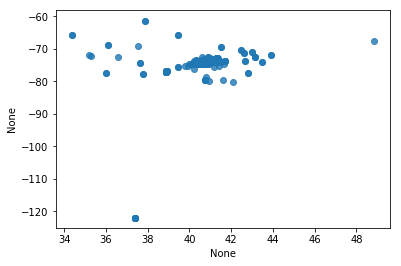

In [26]:
sns.regplot(x=coord_lat, y=coord_lon, fit_reg=False, color=None)
plt.show()

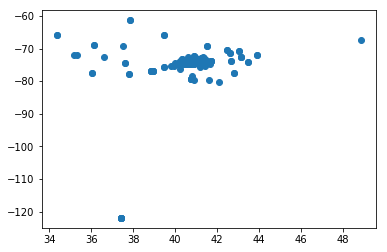

In [27]:
plt.scatter(coord_lat, coord_lon,vmin=None, vmax=None)
plt.show()

# PCA

In [28]:
pca = PCA(random_state=0).fit(coord_all)
pca

PCA(copy=True, iterated_power='auto', n_components=None, random_state=0,
  svd_solver='auto', tol=0.0, whiten=False)

In [29]:
#PCA
train['pickup_pca0'] = pca.transform(train[['pickup_latitude', 'pickup_longitude']])[:, 0]
train['pickup_pca1'] = pca.transform(train[['pickup_latitude', 'pickup_longitude']])[:, 1]
train['dropoff_pca0'] = pca.transform(train[['dropoff_latitude', 'dropoff_longitude']])[:, 0]
train['dropoff_pca1'] = pca.transform(train[['dropoff_latitude', 'dropoff_longitude']])[:, 1]
test['pickup_pca0'] = pca.transform(test[['pickup_latitude', 'pickup_longitude']])[:, 0]
test['pickup_pca1'] = pca.transform(test[['pickup_latitude', 'pickup_longitude']])[:, 1]
test['dropoff_pca0'] = pca.transform(test[['dropoff_latitude', 'dropoff_longitude']])[:, 0]
test['dropoff_pca1'] = pca.transform(test[['dropoff_latitude', 'dropoff_longitude']])[:, 1]

In [1]:
train.head()

NameError: name 'train' is not defined

# 1.2.d.3 Clustering
- DBSCAN

In [ ]:
dbscan = DBSCAN(n_jobs=-1).fit(coord_all)

In [ ]:
dbscan

# 3. Modeling

# evaluation metric

[Root Mean Squared Logarithmic Error](https://www.kaggle.com/wiki/RootMeanSquaredLogarithmicError)

$\epsilon = \sqrt{\frac{1}{n} \sum_{i=1}^n (\log(p_i + 1) - \log(a_i+1))^2 }$

Where:
- ϵ is the RMSLE value (score)

- n is the total number of observations in the (public/private) data set,

- pi is your prediction of trip duration, and
- ai is the actual trip duration for i. 
- log(x) is the natural logarithm of x

### data type manipulation
- categorical data convert encoding

In [ ]:
train['store_and_fwd_flag'] = 1 * (train.store_and_fwd_flag.values == 'Y')
test['store_and_fwd_flag'] = 1 * (test.store_and_fwd_flag.values == 'Y')

In [77]:
train = train.drop('id', axis=1)
test = test.drop('id', axis=1)

In [82]:
# train = pd.get_dummies(train)
# test = pd.get_dummies(test)

In [83]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1456562 entries, 0 to 1458643
Data columns (total 22 columns):
vendor_id             1456562 non-null float64
pickup_datetime       1456562 non-null datetime64[ns]
passenger_count       1456562 non-null float64
pickup_longitude      1456562 non-null float64
pickup_latitude       1456562 non-null float64
dropoff_longitude     1456562 non-null float64
dropoff_latitude      1456562 non-null float64
store_and_fwd_flag    1456562 non-null int64
trip_duration         1456562 non-null float64
trip_sec              1456562 non-null float64
pick_dayofweek        1456562 non-null float64
pick_dayofmonth       1456562 non-null float64
pick_datehour         1456562 non-null float64
distance              1456562 non-null float64
manhattan_distance    1456562 non-null float64
bearing               1456562 non-null float64
pickup_pca0           1456562 non-null float64
pickup_pca1           1456562 non-null float64
dropoff_pca0          1456562 non-nu

In [84]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 625134 entries, 0 to 625133
Data columns (total 20 columns):
vendor_id             625134 non-null int64
pickup_datetime       625134 non-null datetime64[ns]
passenger_count       625134 non-null int64
pickup_longitude      625134 non-null float64
pickup_latitude       625134 non-null float64
dropoff_longitude     625134 non-null float64
dropoff_latitude      625134 non-null float64
store_and_fwd_flag    625134 non-null int64
pick_dayofweek        625134 non-null int64
pick_dayofmonth       625134 non-null int64
pick_datehour         625134 non-null int64
distance              625134 non-null float64
manhattan_distance    625134 non-null float64
bearing               625134 non-null float64
pickup_pca0           625134 non-null float64
pickup_pca1           625134 non-null float64
dropoff_pca0          625134 non-null float64
dropoff_pca1          625134 non-null float64
pickup_cluster        625134 non-null int32
dropoff_cluster       

In [86]:
X_train = train.drop(labels = ["trip_duration","trip_sec", "pickup_datetime"], axis=1)
Y_train = train["trip_duration"]
X_test  = test.drop(labels = ["pickup_datetime"], axis=1).copy()
X_train.shape, Y_train.shape, X_test.shape

((1456562, 19), (1456562,), (625134, 19))

In [100]:
import statsmodels.api as sm

In [101]:
OLS_model = sm.OLS(Y_train, X_train).fit()
print(OLS_model.summary())

                            OLS Regression Results                            
Dep. Variable:          trip_duration   R-squared:                       0.567
Model:                            OLS   Adj. R-squared:                  0.567
Method:                 Least Squares   F-statistic:                 1.273e+05
Date:                Tue, 03 Apr 2018   Prob (F-statistic):               0.00
Time:                        16:29:08   Log-Likelihood:            -1.0963e+07
No. Observations:             1456562   AIC:                         2.193e+07
Df Residuals:                 1456546   BIC:                         2.193e+07
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
vendor_id              2.4160      0

In [96]:
Y_test = OLS_model.predict(X_test)
Y_test.head(), len(Y_test)

sub = pd.DataFrame(columns= ['id', 'trip_duration'])
sub['id'] = sample_submission["id"]
sub['trip_duration'] = Y_test
sub.to_csv('submission_OLS.csv',index=False)

# Appendix

### 1. degree of decimal
- 0.000001 = 1.11mm

### 2. spatial data analysis
- PCA
- discriminant analysis

### 3. clustering
- K means
- K nearest neighbor
- Expectation Maximization

### 4. ensemble methods
- aggregation
- boosting

# decision tree

In [92]:
from sklearn.tree import DecisionTreeRegressor

In [93]:

# Regression
import scipy
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from sklearn.cross_validation import cross_val_score
# Decission Tree regressor
from sklearn.tree import DecisionTreeRegressor


/home/jk/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [99]:
model_dt=DecisionTreeRegressor(max_depth=4).fit(X_train,Y_train)

In [104]:
y_tree = model_dt.predict(X_test)

sub = pd.DataFrame(columns= ['id', 'trip_duration'])
sub['id'] = sample_submission["id"]
sub['trip_duration'] = y_tree
sub.to_csv('submission_tree.csv',index=False)

# random forest

In [105]:
from sklearn.ensemble import RandomForestRegressor

In [107]:
model_rnd_frst=RandomForestRegressor(max_depth=4, n_jobs=4)
model_rnd_frst.fit(X_train, Y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=4,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=4,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [109]:
y_random = model_rnd_frst.predict(X_test)

sub = pd.DataFrame(columns= ['id', 'trip_duration'])
sub['id'] = sample_submission["id"]
sub['trip_duration'] = y_random
sub.to_csv('submission_random.csv',index=False)

# XGBoost

In [111]:
import xgboost as xgb

In [116]:
model_xgb = xgb.XGBRegressor(max_depth=15, n_jobs=4, reg_alpha=0.5, reg_lambda=0.5, random_state=0).fit(X_train, Y_train)

In [117]:
y_xgb = model_xgb.predict(X_test)

sub = pd.DataFrame(columns= ['id', 'trip_duration'])
sub['id'] = sample_submission["id"]
sub['trip_duration'] = y_xgb
sub.to_csv('submission_xgb.csv',index=False)
#0.42123

In [ ]:
model_xgb = xgb.train()